# SYNERGY SUMMER SCHOOL

The notebook presents the optimization of a real-world problem (Welded Beam Design) with a multiobjective optimization algorithm (NSGA2)

# NSGA2 algorithm

K. Deb, S. Agrawal, A. Pratab and T. Meyarivan, "A fast and elitist multiobjective genetic algorithm: NSGA-II," 
IEEE Transactions on Evolutionary Computation, Vol. 6, No. 2, pp. 182-197, 2002. http://ieeexplore.ieee.org/document/996017/

## Algorithm implementation: DEAP package

- https://github.com/DEAP/deap
- https://deap.readthedocs.io/en/master/
- https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py

In [1]:
from IPython.display import IFrame
IFrame("./NSGA-II.pdf", width='100%', height=600)

# Test problem


### Welded Beam Design Optimization

A rigid member is welded onto a beam, with a load applied to the end of the member. 
The total cost of production is equal to the labor costs (a function of the weld dimensions) plus the cost 
of the weld and beam material. 
The problem has four real-parameter variables (b, h, l, t) and four non-linear constraints. 
One of the two objectives is to minimize the cost of production and 
other is to minimize the end deflection of the welded beam

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.420.4706&rep=rep1&type=pdf

In [2]:
from IPython.display import Image
Image(url= "./Schematic-view-of-a-welded-beam-design-optimization-problem.png")

In [3]:
IFrame("./welded_beam_design.pdf", width='100%', height=600)

## Imports

In [4]:
%matplotlib notebook

import array
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, tanh
import os
import ctypes

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

from ipywidgets import widgets, Layout, Button, Box

import warnings
warnings.simplefilter('ignore')

## Evaluation function in Python

In [5]:
def welded_beam_design(x):
    #problem encoding
    b = 0.125 + 4.875 * x[0]
    h = 0.125 + (b - 0.125) * x[1]   
    l = 0.1 + 9.9 * x[2]
    t = 0.1 + 9.9 * x[3]

    # auxiliary terms
    sigma = 504000.0 / (t*t * b)
    tau1 = 6000.0 / (sqrt(2.0) * h * l)
    tau2 = 6000.0 * (14.0 + 0.5*l) * sqrt(0.25 * (l*l + (h+t)*(h+t))) / (1.414 * h*l * (l*l/12.0 + 0.25*(h+t)*(h+t)))
    tau = sqrt(tau1*tau1 + tau2*tau2 + l*tau1*tau2 / sqrt(0.25 * (l*l + (h+t)*(h+t))))
    P_c = 64746.022 * (1.0 - 0.0282346*t) * t * b*b*b

    # fitness functions
    f1 = 1.10471 * h*h * l + 0.04811 * t * b * (14.0 + l)
    f2 = 2.1952 / (t*t*t * b)

    # scaling roughly to range [0, 1]
    f1 /= 40.0
    f2 /= 0.006

    # constraints
    g1 = tau - 13600.0
    g2 = sigma - 30000.0
    g3 = 6000.0 - P_c

    # penalty for constraint violations
    penalty = (max(1e-6 * g1, 0.0) + max(1e-6 * g2, 0.0) + max(1e-7 * g3, 0.0))
    if penalty > 0.0:
        penalty += 0.5
    f1 += penalty
    f2 += penalty
     
    # non-linearly rescaled fitness
    return [tanh(f1),tanh(f2)]

## Evaluation function in external C Windows/Linux library 

In [6]:
if (os.name == 'nt'):
    evaluation_functions_api = ctypes.CDLL('./EvaluationFunctions.dll')
else:
    evaluation_functions_api = ctypes.CDLL('./EvaluationFunctions.so')

evaluation_functions_api.welded_beam_design.argtypes = [ctypes.POINTER(ctypes.c_double)]
evaluation_functions_api.welded_beam_design.restype = ctypes.POINTER(ctypes.c_double)

def welded_beam_design_api(x):
    x_c = (ctypes.c_double*4)()
    x_c[0]=ctypes.c_double(x[0])
    x_c[1]=ctypes.c_double(x[1])
    x_c[2]=ctypes.c_double(x[2])
    x_c[3]=ctypes.c_double(x[3])
    res_c = evaluation_functions_api.welded_beam_design(x_c)
    return [res_c[0], res_c[1]]

## Algorithm set up

In [7]:
use_external_library_for_evaluation = True

if use_external_library_for_evaluation:
    evaluation_function = welded_beam_design_api  
else:
    evaluation_function = welded_beam_design
number_of_attributes = 4
optimization_type = (-1.0, -1.0)  # -1..minimization, 1..maximization
objective_name = ["Production cost", "Welded beam deflection"]
objective_limit = [[0, 1], [0, 1]]
attribute_bound_lower, attribute_bound_upper = 0.0, 1.0
reference_point = [1.1, 1.1]
hypervolume_upper_limit = reference_point[0] * reference_point[1]

## Auxiliary functions

In [8]:
def initialization_uniform(bound_lower, bound_upper, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(bound_lower, bound_upper)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([bound_lower] * size, [bound_upper] * size)]
    
    
def fitness_data(population):
    fitness_array_data = []
    for individual in population:
        fitness_array_data += [individual.fitness.values]    
    fitness_array_data = np.array(fitness_array_data)
    return fitness_array_data


def plot_data(plot, data, marker):
    plot.plot(data[:,0], data[:,1], marker) 

# NSGA2 algorithm

In [9]:
##################################
# global definitions
##################################

# fitness: fitness weights define minimization or maximization
creator.create("Fitness", base.Fitness, weights=optimization_type)
    
# individual: consists of array of values
creator.create("Individual", array.array, typecode='d', fitness=creator.Fitness)

# set of tools for performing algorithms steps
toolbox = base.Toolbox()

# define array of attributes (of individuals) with lower and upper bounds
toolbox.register("attribute_float", initialization_uniform, attribute_bound_lower, attribute_bound_upper, 
                     number_of_attributes)
    
# define individuals as arrays of attributes
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attribute_float)
    
# define population as list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
# define evaluation function
toolbox.register("evaluate", evaluation_function)
    
# define binary crossover, take into account bounds of seach space
# a high eta will produce children resembling to their parents, while a small eta will produce children much more different.
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=attribute_bound_lower, up=attribute_bound_upper, eta=20.0)

# define polynomial mutation, take into account bounds of seach space
# a high eta will produce children resembling to their parents, while a small eta will produce children much more different.
toolbox.register("mutate", tools.mutPolynomialBounded, low=attribute_bound_lower, up=attribute_bound_upper, eta=20.0,
                indpb=0.1)

# define selection, the one in NSGA2
toolbox.register("select", tools.selNSGA2)


##################################
# main function
##################################

def optimize(population_size, number_of_generations, crossover_probability, mutation_probability):
    # set mutation probability
    toolbox.mutate.indpb = mutation_probability
    
    # initialize population with pop_size individuals
    population = toolbox.population(n=population_size)

    # evaluate the individuals
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
        
    # just to assign crowding distance
    population = toolbox.select(population, len(population))

    # save hypervolume
    hypervolume_history = np.array([[0,0]])

    # begin generational process
    for generation in range(1, number_of_generations):
        # tournament selection based on dominance (D) between two individuals, 
        # if the two individuals do not interdominate the selection is made based on crowding distance (CD)
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = [toolbox.clone(ind) for ind in offspring]        
   
        # for every consecutive pair of offspring
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            # perform crossover
            if random.random() <= crossover_probability:
                toolbox.mate(ind1, ind2)

            # perform mutation
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)

        # evaluate individuals
        fitnesses = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit

        # select next generation population
        population = toolbox.select(population + offspring, population_size)        
        
        # find nondominated individuals
        nondominated_individuals = tools.sortNondominated(population, len(population))[0]
        
        # plot data
        hypervolume_subfigure.clear()
        objective_space_subfigure.clear()
        hypervolume_value = hypervolume(population, reference_point)
        hypervolume_history = np.append(hypervolume_history,np.array([[generation, hypervolume_value]]), axis = 0) 
        plot_data(hypervolume_subfigure, hypervolume_history, '-')   
        hypervolume_subfigure.set_title('Hypervolume through generations')
        hypervolume_subfigure.set_xlabel('Generation')
        hypervolume_subfigure.set_ylabel('Hypervolume')
        hypervolume_subfigure.set_ybound([0, hypervolume_upper_limit])
        
        pop_fitness_data = fitness_data(nondominated_individuals)         
        plot_data(objective_space_subfigure, pop_fitness_data, '.')  
        objective_space_subfigure.set_title('Objective space')
        objective_space_subfigure.set_xlabel(objective_name[0])
        objective_space_subfigure.set_ylabel(objective_name[1])
        objective_space_subfigure.set_xbound(objective_limit[0])
        objective_space_subfigure.set_ybound(objective_limit[1])
        main_figure.canvas.draw() 
    
    return hypervolume_value

## Algorithm evaluation

<IPython.core.display.Javascript object>


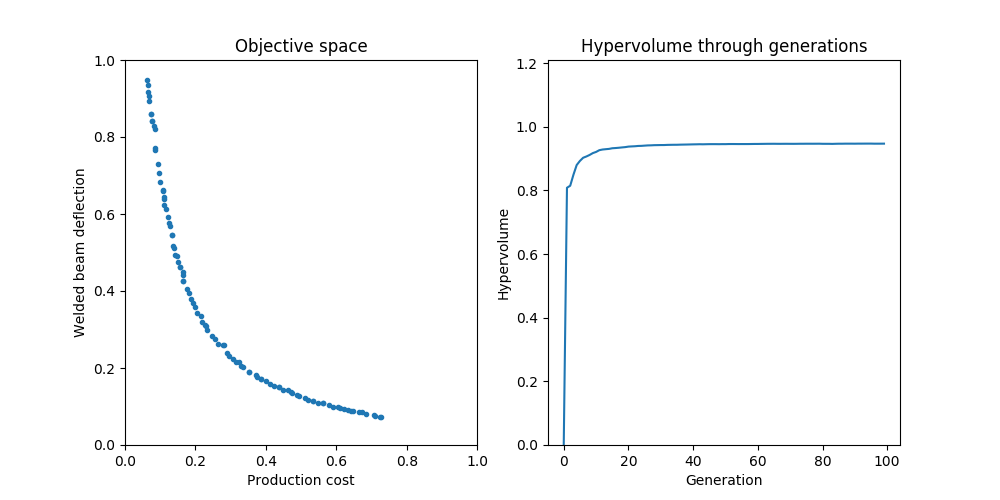

Population size: 100
Number of generations: 100
Crossover probability: 0.9
Mutation probability: 0.1
Final hypervolume: 0.947110
****************************************


In [10]:
population_size_label = widgets.Label(value="Population size:")
population_size_slider = widgets.IntSlider(value=100, min=20, max=400, step=20, disabled=False, continuous_update=False, 
                            orientation='horizontal', readout=True, readout_format='d')
number_of_generations_label = widgets.Label(value="Number of generations:")
number_of_generations_slider = widgets.IntSlider(value=100, min=20, max=200, step=20, disabled=False, continuous_update=False, 
                            orientation='horizontal', readout=True, readout_format='d')
crossover_probability_label = widgets.Label(value="Crossover probability:")
crossover_probability_slider = widgets.FloatSlider(value=0.9, min=0.0, max=1.0, step=0.01, disabled=False, 
                                    continuous_update=False, orientation='horizontal',readout=True, readout_format='.2f')
mutation_probability_label = widgets.Label(value="Mutation probability:")
mutation_probability_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, disabled=False, 
                                    continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
evolution_button = Button(description='Start evolution')

box_layout = Layout(display='flex', flex_flow='column', align_items='center', border='none',width='80%')

label_box = widgets.VBox([population_size_label, number_of_generations_label, crossover_probability_label,
                         mutation_probability_label])
slider_box = widgets.VBox([population_size_slider, number_of_generations_slider, crossover_probability_slider, 
                          mutation_probability_slider])
label_slider_box = widgets.HBox([label_box, slider_box])

main_figure = None
objective_space_subfigure = None
hypervolume_subfigure = None

def on_button_clicked(b):
    global main_figure
    global objective_space_subfigure
    global hypervolume_subfigure
    if main_figure is None:
        main_figure = plt.figure(figsize=(10,5))
        objective_space_subfigure = main_figure.add_subplot(121)
        hypervolume_subfigure = main_figure.add_subplot(122)
        plt.ion()
        main_figure.show()
        main_figure.canvas.draw() 
    evolution_button.disabled = True
    evolution_button.description = "Evolution in progress..."
    print("Population size: "+str(population_size_slider.value))
    print("Number of generations: "+str(number_of_generations_slider.value))
    print("Crossover probability: "+str(crossover_probability_slider.value))
    print("Mutation probability: "+str(mutation_probability_slider.value))
    hypervolume_value = optimize(population_size_slider.value, number_of_generations_slider.value, 
                                 crossover_probability_slider.value, mutation_probability_slider.value)
    print("Final hypervolume: %f" % hypervolume_value)
    print("****************************************")
    evolution_button.description = "Start evolution"
    evolution_button.disabled = False

evolution_button.on_click(on_button_clicked)

top_label = widgets.Label(value="Optimization parameters", layout=Layout(width='80%'))

box_all = Box(children=[top_label, label_slider_box, evolution_button], layout=box_layout)
box_all